<a href="https://www.kaggle.com/code/arminatc/sorghum-fastai?scriptVersionId=95291139" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from fastai.vision.all import *

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import torch
mpl.rcParams["figure.figsize"] = (18,12)

In [3]:
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [4]:
torch.cuda.set_device(0)

In [5]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

In [6]:
path = Path('../input/sorghum-id-fgvc-9')
path.ls()

(#4) [Path('../input/sorghum-id-fgvc-9/sample_submission.csv'),Path('../input/sorghum-id-fgvc-9/train_cultivar_mapping.csv'),Path('../input/sorghum-id-fgvc-9/train_images'),Path('../input/sorghum-id-fgvc-9/test')]

# Data exploration

In [7]:
sorghum_df = pd.read_csv(path/'train_cultivar_mapping.csv')
sorghum_df.head(10)

,image,cultivar
0,2017-06-16__12-24-20-930.png,PI_257599
1,2017-06-02__16-48-57-866.png,PI_154987
2,2017-06-12__13-18-07-707.png,PI_92270
3,2017-06-22__13-18-06-841.png,PI_152651
4,2017-06-26__12-56-48-642.png,PI_176766
5,2017-06-05__12-30-08-470.png,PI_156330
6,2017-06-18__13-23-50-617.png,PI_329299
7,2017-06-15__14-08-45-158.png,PI_52606
8,2017-06-13__10-47-59-932.png,PI_145633
9,2017-06-20__12-22-35-820.png,PI_273969


In [8]:
allowed_image = []
for i in (path/'train_images').ls():
    va = i.name in sorghum_df.image.to_list()
    if va:
        allowed_image.append(i.name)

In [9]:
sorghum_df = sorghum_df[sorghum_df.image.isin(allowed_image)]

<AxesSubplot:>

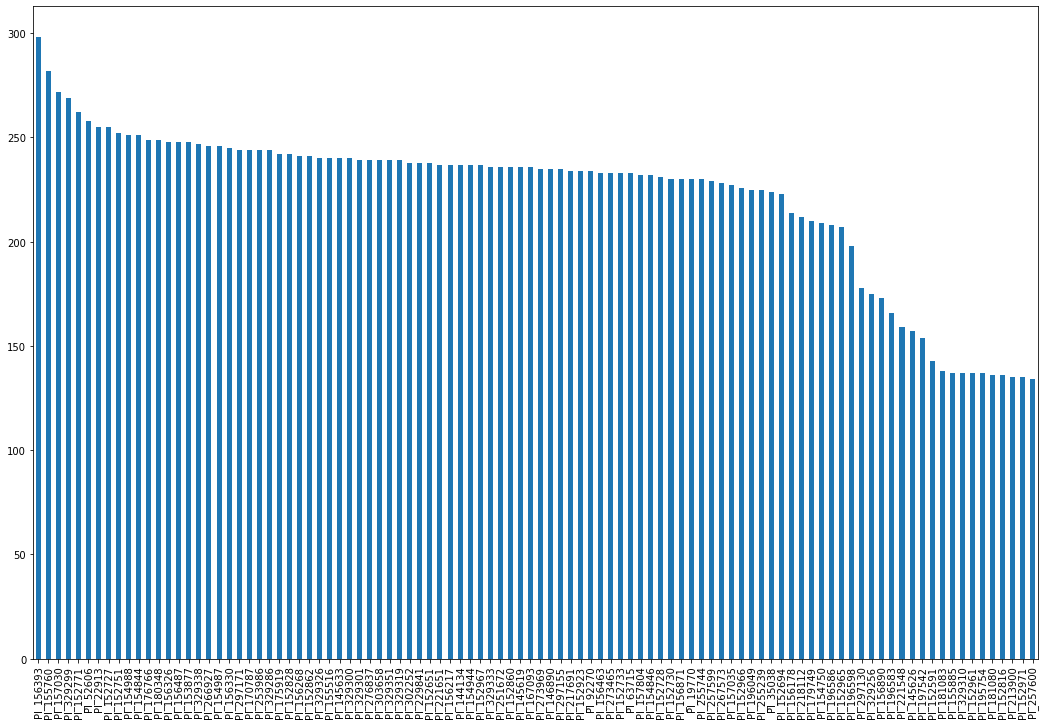

In [10]:
sorghum_df.cultivar.value_counts().plot(kind='bar')

# DataLoaders

In [12]:
dls = ImageDataLoaders.from_df(
    sorghum_df,
    path/'train_images',
    valid_pct=0.10,
    item_tfms=Resize(460),
    batch_tfms=[
        *aug_transforms(size=224, min_scale=0.75),
        Normalize.from_stats(*imagenet_stats)
    ],
    bs=64,
    num_workers=4,
    label_col="cultivar")

Could not do one pass in your dataloader, there is something wrong in it. Please see the stack trace below:


RuntimeError: solve: MAGMA library not found in compilation. Please rebuild with MAGMA.

In [ ]:
dls.show_batch()

# Create the Learner

In [ ]:
learn = cnn_learner(
    dls,
    resnet50,
    metrics=[error_rate, accuracy],
    model_dir="/tmp/model/").to_fp16()

In [ ]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    model.lr_find()
    
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

In [ ]:
%time lr_to_use = find_appropriate_lr(learn)

In [ ]:
lr_to_use

# Training

In [ ]:
%time learn.fine_tune(10, lr_to_use)

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

In [ ]:
interp.plot_confusion_matrix(figsize=(20,20))

# Predictions

In [ ]:
test_dl = dls.test_dl(get_image_files(path/'test'))

In [ ]:
log_preds_test = learn.get_preds(dl=test_dl)
log_preds_test = np.argmax(log_preds_test[0], axis = 1)
preds_classes = [dls.vocab[i] for i in log_preds_test]
probs = np.exp(log_preds_test)

In [ ]:
submission = pd.DataFrame({ 'filename': os.listdir(path/'test'), 'cultivar': preds_classes })

In [ ]:
submission

In [ ]:
submission.to_csv('submission.csv', index=False)